# Multi-period modelling in oemof-solph (Tutorial)
Welcome to this tutorial! :-)

You will learn how to use the new multi-period modelling feature from oemof.solph v0.5.1.<br> 
To be able to run the code, make sure you have all the necessary dependencies installed. Check out the README.md for info on that.

Now let's get started rightaways!

# Package imports
First, we need to import the required packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import oemof.solph as solph

from multiperiod_tutorial.analyze_results import (
    prepare_results, plot_single_investment_variable_multiple_dfs
)

# Define some settings
Before we get started, we define some global settings here.

In [2]:
# If you want to use another solver, please change the variable here
solver = "cbc"  # cbc, cplex, gurobi, gplk
# Ensure that fontsize in plots is well readable
plt.rcParams.update({'font.size': 12})

# Set up the energy system
For this example, we set up a simplistic energy system.
Graph of energy system


## Define time index and periods
The first thing we do, is to define our time index and the periods.<br>
To keep out example simple, we only consider three periods, corresponding to the years 2020, 2030 and 2040 with three hourly timesteps each.

In [3]:
# Define three pd.date_range objects
t_idx_1 = pd.date_range("1/1/2020", periods=3, freq="H")
t_idx_2 = pd.date_range("1/1/2030", periods=3, freq="H")
t_idx_3 = pd.date_range("1/1/2040", periods=3, freq="H")

# Transfer them to pd.Series
t_idx_1_series = pd.Series(index=t_idx_1, dtype="float64")
t_idx_2_series = pd.Series(index=t_idx_2, dtype="float64")
t_idx_3_series = pd.Series(index=t_idx_3, dtype="float64")

# Combine them and use the index as pd.DatetimeIndex
timeindex = pd.concat(
    [t_idx_1_series, t_idx_2_series, t_idx_3_series]
).index

# periods are a list of pd.date_range objects
periods = [t_idx_1, t_idx_2, t_idx_3]

## Define the actual energy system
> **Important** to notice:
> 1. You explicitly have to define the `periods` attribute.
> 2. You can define both, `timeindex` and `timeincrement` for multi-period modelling. But you have to exercise caution that they are consistent with each other.
> 3. You have to set `infer_last_interval=False`. The multi-period feature in this regard is not (yet) fully aligned with the default behaviour of oemof.solph.

Note that `SuspiciousUsageWarnings` pop up:
* This is intended behaviour informing you that what you do is new and somewhat experimental (though succesfully tested).
* Also it warns you to pay attention on how to define `timeindex` and `timeincrement` in case you specify both.

In [4]:
es = solph.EnergySystem(
    timeindex=timeindex,
    timeincrement=[1] * len(timeindex),
    periods=periods,
    infer_last_interval=False,
)

C:\mambaforge-data\envs\multi_period_oemof\lib\site-packages\oemof\solph\_energy_system.py:139: SuspiciousUsageWarning: Ensure that your timeindex and timeincrement are consistent.
If you are not considering non-equidistant timeindices, consider only specifying a timeindex.
  warnings.warn(msg, debugging.SuspiciousUsageWarning)
C:\mambaforge-data\envs\multi_period_oemof\lib\site-packages\oemof\solph\_energy_system.py:170: SuspiciousUsageWarning: CAUTION! You specified the 'periods' attribute for your energy system.
 This will lead to creating a multi-period optimization modeling which can be used e.g. for long-term investment modeling.
Please be aware that the feature is experimental as of now. If you find anything suspicious or any bugs, please report them.
  warnings.warn(msg, debugging.SuspiciousUsageWarning)


## Define components
Now, let's equip our energy system with some components.

### Buses
Defining buses is nothing special, it is exactly what you are used to.<br>
For our example, we use the following buses:

| bus | explanation |
|---|---|
| `bus_lignite` | commodity bus for fuel lignite |
| `bus_hardcoal` | commodity bus for fuel hard coal |
| `bus_natgas` | commodity bus for fuel natural gas |
| `bus_el` | electricity bus for Germany |
| `bus_FR` | electricity bus for France |

In [5]:
# Create buses
bus_lignite = solph.buses.Bus(label="DE_bus_lignite", balanced=True)
bus_hardcoal = solph.buses.Bus(label="DE_bus_hardcoal", balanced=True)
bus_natgas = solph.buses.Bus(label="DE_bus_natgas", balanced=True)
bus_el = solph.buses.Bus(label="DE_bus_el", balanced=True)
bus_el_FR = solph.buses.Bus(label="FR_bus_el", balanced=True)

# Add them to the energy system
es.add(
    bus_lignite,
    bus_hardcoal,
    bus_natgas,
    bus_el,
    bus_el_FR,
)

### Sources and Sinks
Defining sources and sinks again is nothing special, it is exactly what you are used to.<br>
For our example, we use the following sources and sinks:

| component | explanation | type | region |
|---|---|---|---|
| `source_lignite` | commodity source for fuel lignite | Source | Germany |
| `source_hardcoal` | commodity source for fuel hard coal | Source | Germany |
| `source_natgas` | commodity source for fuel natural gas | Source | Germany |
| `source_wind` | wind generation source | Source | Germany |
| `source_shortage` | artifical shortage source | Source | Germany |
| `source_wind_FR` | wind generation source | Source | France |
| `source_shortage_FR` | artifical shortage source | Source | France |
| `sink_el` | electricity consumption | Sink | Germany |
| `sink_excess` | excess electricity sink | Sink | Germany |
| `sink_el_FR` | electricity consumption | Sink | France |
| `sink_excess_FR` | excess electricity sink | Sink | France | 

> Tips and hints:
> 1. Note that the "wind" sources are somewhat generic and don't really show a typical wind output profile.
> 2. My tip is to always include shortage sources and excess sinks to ensure model feasibility.

In [6]:
# Create sources
source_lignite = solph.components.Source(
    label="DE_source_lignite",
    outputs={bus_lignite: solph.flows.Flow(variable_costs=5)},
)
source_hardcoal = solph.components.Source(
    label="DE_source_hardcoal",
    outputs={bus_hardcoal: solph.flows.Flow(variable_costs=10)},
)
source_natgas = solph.components.Source(
    label="DE_source_natgas",
    outputs={bus_natgas: solph.flows.Flow(variable_costs=20)},
)
source_wind = solph.components.Source(
    label="DE_source_wind",
    outputs={
        bus_el: solph.flows.Flow(
            variable_costs=0,
            fix=[110] + [70] * (len(timeindex) - 1),
            nominal_value=1,
        )
    },
)
source_shortage = solph.components.Source(
    label="DE_source_shortage",
    outputs={
        bus_el: solph.flows.Flow(variable_costs=1e10, nominal_value=1e10)
    },
)
source_wind_FR = solph.components.Source(
    label="FR_source_wind",
    outputs={
        bus_el_FR: solph.flows.Flow(
            variable_costs=0,
            fix=[45] * len(timeindex),
            nominal_value=1,
        )
    },
)
source_shortage_FR = solph.components.Source(
    label="FR_source_shortage",
    outputs={
        bus_el_FR: solph.flows.Flow(variable_costs=1e10, nominal_value=1e10)
    },
)

# Create sinks
sink_el = solph.components.Sink(
    label="DE_sink_el",
    inputs={
        bus_el: solph.flows.Flow(fix=[80] * len(timeindex), nominal_value=1)
    },
)
sink_excess = solph.components.Sink(
    label="DE_sink_excess",
    inputs={
        bus_el: solph.flows.Flow(variable_costs=1e10, nominal_value=1e10)
    },
)
sink_el_FR = solph.components.Sink(
    label="FR_sink_el",
    inputs={
        bus_el_FR: solph.flows.Flow(
            fix=[50] * len(timeindex), nominal_value=1
        )
    },
)
sink_excess_FR = solph.components.Sink(
    label="FR_sink_excess",
    inputs={
        bus_el_FR: solph.flows.Flow(variable_costs=1e3, nominal_value=1e10)
    },
)

# Add sources and sinks to the energy system
es.add(
    source_lignite,
    source_hardcoal,
    source_natgas,
    source_wind,
    source_shortage,
    source_wind_FR,
    source_shortage_FR,
    sink_el,
    sink_excess,
    sink_el_FR,
    sink_excess_FR,
)

### Generators (Transformers)
Now we add some generators to our example.<br>
Note that this is the first place, where we have differences compared to a standard model:
* the `Investment` option now comes with some additional attributes:
  * `age`: initial age of our plant (in years)
  * `lifetime`: technical lifetime of our plant (in years)
  * `interest_rate`: required interest rate for the investment; applying a weighted average costs of capital (WACC) approach.
  * `fixed_costs`: the fixed costs that are applied over the plants lifetime. Values per period can be given.
  * `ep_costs`: differs compared to the usage in the standard model: Includes the nominal or real investment expenses. Values per period can be given.
  * `maximum`: is now the maximum that can be installed per period.
* Besides the investment option, in our example the remainder is the same.

The following generators are defined:

| component | explanation | fuel | technology | region |
|---|---|---|---|---|
| `pp_lignite` | lignite power plant | lignite | steam turbine | Germany |
| `pp_hardcoal` | hard coal power plant | hard coal | steam turbine | Germany |
| `pp_natgas_CCGT` | combined cycle natural gas power plant | natural gas | combined cycle gas turbine | Germany |
| `pp_natgas_GT` | natural gas power plant | natural gas | gas turbine | Germany |

> Note:
> * We could have defined plants that have no `Investment` option, i.e. that are "dispatch-only" plants already in the system.
> * We could have attributed these with an `age` and a `lifetime`. If we don't provide this, they remain in the system "forever".
> * You are also allowed to use the `fixed_costs` attribute for these plants.

In [7]:
# Create transformers
pp_lignite = solph.components.Transformer(
    label="DE_pp_lignite",
    inputs={bus_lignite: solph.flows.Flow()},
    outputs={
        bus_el: solph.flows.Flow(
            investment=solph.Investment(
                maximum=1000,
                ep_costs=2e6,
                existing=0,
                lifetime=20,
                age=0,
                interest_rate=0.02,
            ),
            variable_costs=1,
        )
    },
    conversion_factors={bus_el: 0.38},
)

pp_hardcoal = solph.components.Transformer(
    label="DE_pp_hardcoal",
    inputs={bus_hardcoal: solph.flows.Flow()},
    outputs={
        bus_el: solph.flows.Flow(
            investment=solph.Investment(
                maximum=1000,
                ep_costs=1.6e6,
                existing=0,
                lifetime=20,
                age=0,
                interest_rate=0.02,
            ),
            variable_costs=2,
        )
    },
    conversion_factors={bus_el: 0.45},
)

pp_natgas_CCGT = solph.components.Transformer(
    label="DE_pp_natgas_CCGT",
    inputs={bus_natgas: solph.flows.Flow()},
    outputs={
        bus_el: solph.flows.Flow(
            investment=solph.Investment(
                maximum=1000,
                ep_costs=1e6,
                existing=0,
                lifetime=20,
                age=0,
                interest_rate=0.02,
            ),
            variable_costs=3,
        )
    },
    conversion_factors={bus_el: 0.6},
)

pp_natgas_GT = solph.components.Transformer(
    label="DE_pp_natgas_GT",
    inputs={bus_natgas: solph.flows.Flow()},
    outputs={
        bus_el: solph.flows.Flow(
            investment=solph.Investment(
                maximum=1000,
                ep_costs=[0.6e6, 0.5e6, 0.4e6],
                existing=0,
                lifetime=20,
                age=0,
                interest_rate=0.02,
                fixed_costs=1000,
            ),
            variable_costs=4,
        )
    },
    conversion_factors={bus_el: 0.4},
)

# Add them to the energy system
es.add(
    pp_lignite,
    pp_hardcoal,
    pp_natgas_CCGT,
    pp_natgas_GT,
)

### Storage
To spice it up a little, we also add a storage unit.<br>
We add a single rather generic storage that is available for the market area Germany.

In [8]:
# Create a strorage unit
storage_el = solph.components.GenericStorage(
    label="DE_storage_el",
    inputs={
        bus_el: solph.flows.Flow(
            variable_costs=0,
            max=1,
            investment=solph.Investment(
                maximum=20,
                ep_costs=1000,
                existing=2,
                lifetime=10,
                age=1,
                interest_rate=0.02,
            ),
        )
    },
    outputs={
        bus_el: solph.flows.Flow(
            variable_costs=0,
            max=1,
            investment=solph.Investment(
                maximum=20,
                ep_costs=1000,
                existing=2,
                lifetime=10,
                age=1,
                interest_rate=0.02,
            ),
        )
    },
    loss_rate=0,
    initial_storage_level=0,
    max_storage_level=1,
    min_storage_level=0,
    inflow_conversion_factor=0.9,
    outflow_conversion_factor=0.9,
    balanced=True,
    invest_relation_input_output=1,
    invest_relation_input_capacity=1/5,
    invest_relation_output_capacity=None,
    fixed_costs=10,
    investment=solph.Investment(
        maximum=20,
        ep_costs=1000,
        existing=2,
        lifetime=10,
        age=1,
        interest_rate=0.02,
        fixed_costs=10,
    ),
)

# Add it to the energy system
es.add(storage_el)

### Link
Now we need to connect our two market areas Germany and France.<br>
In this example, e use the experimental `Link` component for that that can operate in both ways.

> Note:
> * We could have used two transformers, one for each direction ending up in the same result.
> * We introduce conversion factors slightly below 1. The reason is that then, the model is not agnostic where to put the energy. Also, we would see some transmission losses in reality, right?

In [9]:
# Create a link
link_DE_FR = solph.components.experimental.Link(
    label="link_DE_FR",
    inputs={
        bus_el: solph.flows.Flow(
            nominal_value=10,
        ),
        bus_el_FR: solph.flows.Flow(
            nominal_value=10,
        ),
    },
    outputs={bus_el_FR: solph.flows.Flow(), bus_el: solph.flows.Flow()},
    conversion_factors={
        (bus_el, bus_el_FR): 0.999999,
        (bus_el_FR, bus_el): 0.999999,
    },
)

# Add it to the energy system
es.add(link_DE_FR)

# Set up and solve the model
You need to specify a `discount_rate` for your model:
* If you provide nothing, a default of `0.02` will be used.
* If you want to use costs in real terms throughout, discounting is not necessary. You can achieve that by setting `disount_rate=0`

Solve the model with your favourite solver, defined at the very beginning.

In [10]:
# Build the mathematical optimization model
om = solph.Model(es, discount_rate=0.02)
# Solve the model and show solver log (note: this may differ dependent on the solver you use)
_ = om.solve(solver=solver, solve_kwargs={"tee": True})

C:\mambaforge-data\envs\multi_period_oemof\lib\site-packages\oemof\solph\components\_generic_storage.py:1026: SuspiciousUsageWarning: For a multi-period model, initial_storage_level is not supported.
It is suggested to remove that parameter since it has no effect.
storage_content will be zero, until there is some usable storage  capacity installed.
  warn(warning, debugging.SuspiciousUsageWarning)


Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 18 2023 

command line - C:\Users\koch_j0\Cbc-releases.2.10.10-i686-w64-mingw32-dbg\bin\cbc.exe -printingOptions all -import C:\Users\koch_j0\AppData\Local\Temp\tmpdw5v0rrl.pyomo.lp -stat=1 -solve -solu C:\Users\koch_j0\AppData\Local\Temp\tmpdw5v0rrl.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 89 (-172) rows, 132 (-172) columns and 308 (-345) elements
Statistics for presolved model


Problem has 89 rows, 132 columns (87 with objective) and 308 elements
There are 36 singletons with objective 
Column breakdown:
63 of type 0.0->inf, 68 of type 0.0->up, 0 of type lo->inf, 
1 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
8 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
18 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 63 of type L 0.0, 0 of type L 1.0, 
0 of type L othe

# Obtain model results
We want to look at the dispatch results for the German electricity bus and the investments.<br>
* Note that we have to extract the storage capacity investments separately.
* Also note that we apply some post-processing in order to get nicer shaped results that we can visualize afterwards.

In [11]:
model_results = solph.processing.results(om)
model_results = solph.processing.convert_keys_to_strings(model_results)

# investment results for Germany
investment_results = solph.views.node(model_results, "DE_bus_el")["period_scalars"]
buses_el_views = ["DE_bus_el", "FR_bus_el"]

# dispatch results for Germany
dispatch_results = solph.views.node(model_results, "DE_bus_el")["sequences"]

# Extract storage capacity investments
storage_investment_results = solph.views.node(model_results, "DE_storage_el")["period_scalars"]
capacity_idx = [idx for idx in storage_investment_results.index if idx[0][1] == "None"]
storage_investment_results = storage_investment_results.loc[capacity_idx]

# Do some postprocessing for plotting in the following
investment_results = prepare_results(investment_results)
storage_investment_results = prepare_results(storage_investment_results)
dispatch_results = prepare_results(dispatch_results.T).reset_index(level=1, drop=True).T

# Show the model results

## Investment results
Draw the following plots
* new investments made per period
* decommissionings made per period
* total installed capacity per period

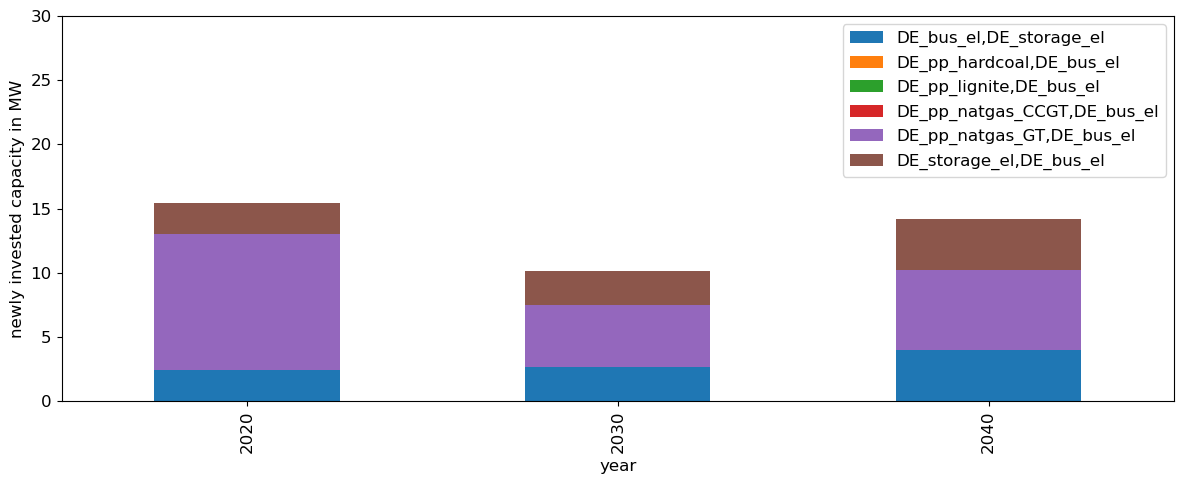

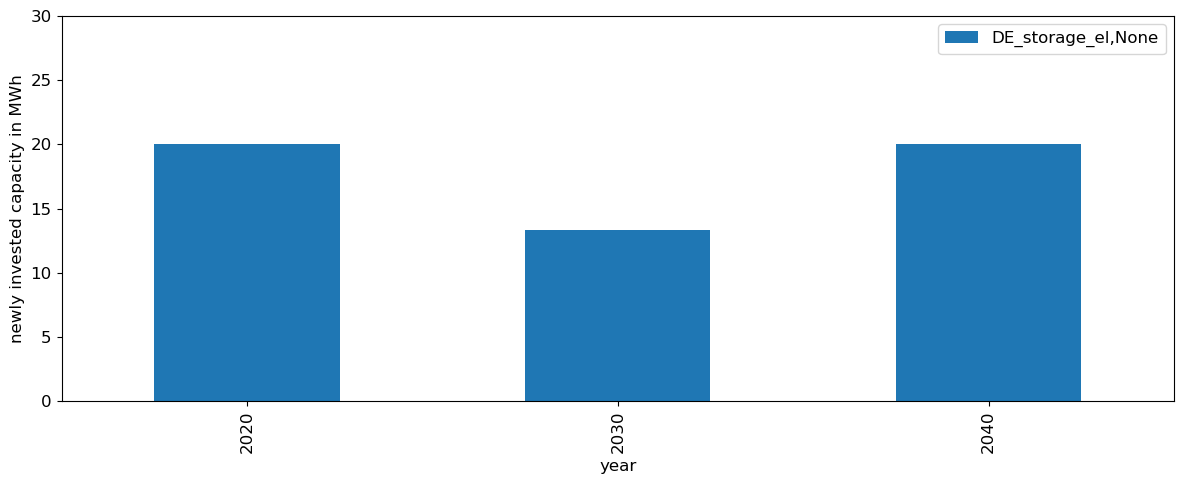

In [12]:
# Show the newly invested capacity
plot_single_investment_variable_multiple_dfs(
    [investment_results, storage_investment_results],
    "invest",
    ylim=[0, 30]
)

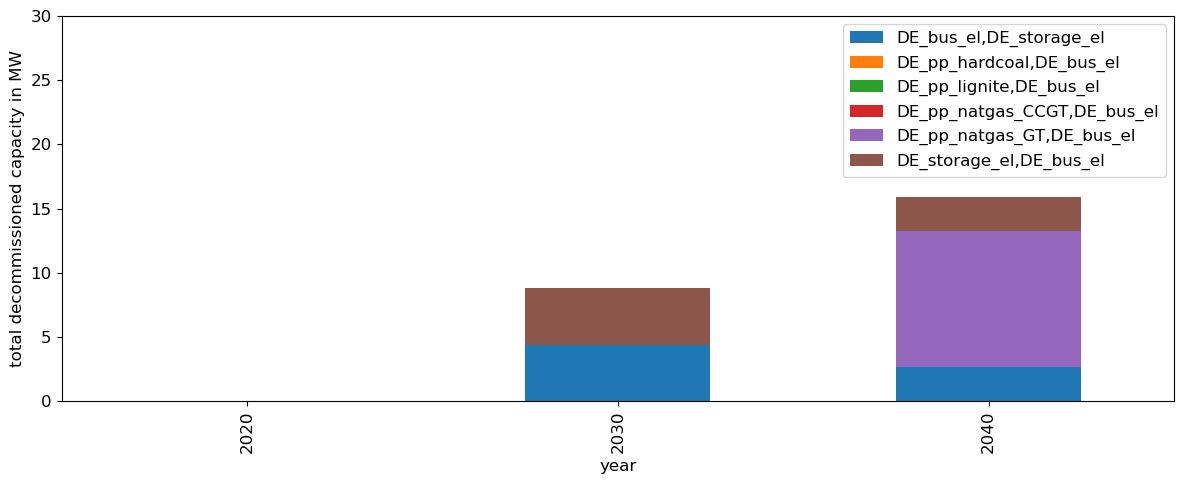

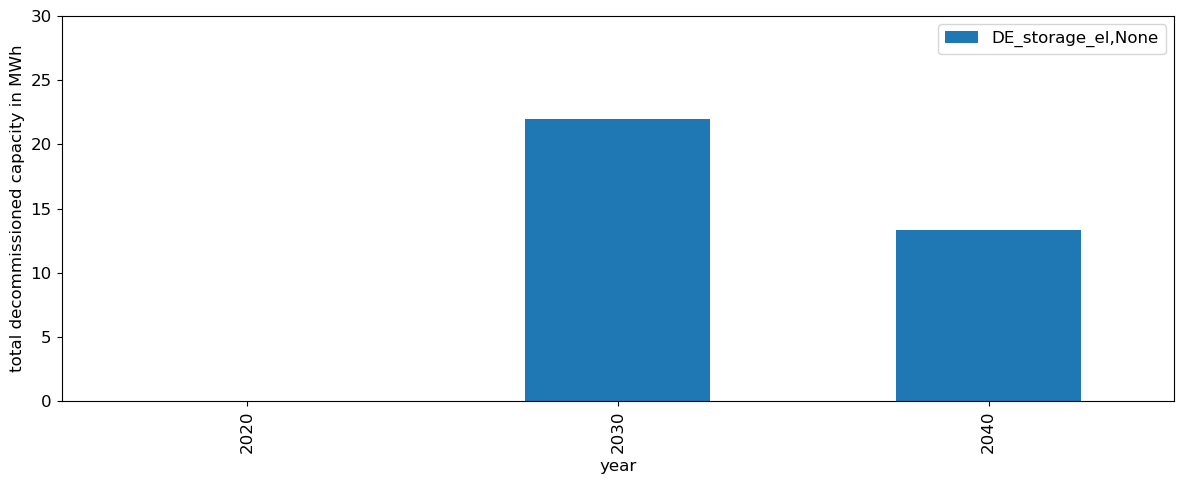

In [13]:
# Show the decommissioned capacity
plot_single_investment_variable_multiple_dfs(
    [investment_results, storage_investment_results],
    "old",
    ylim=[0, 30]
)

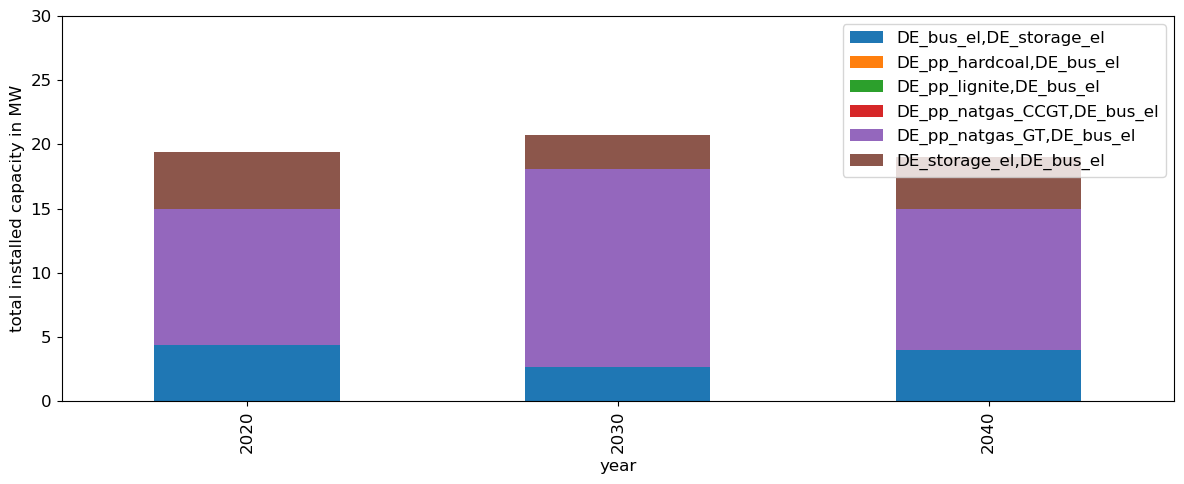

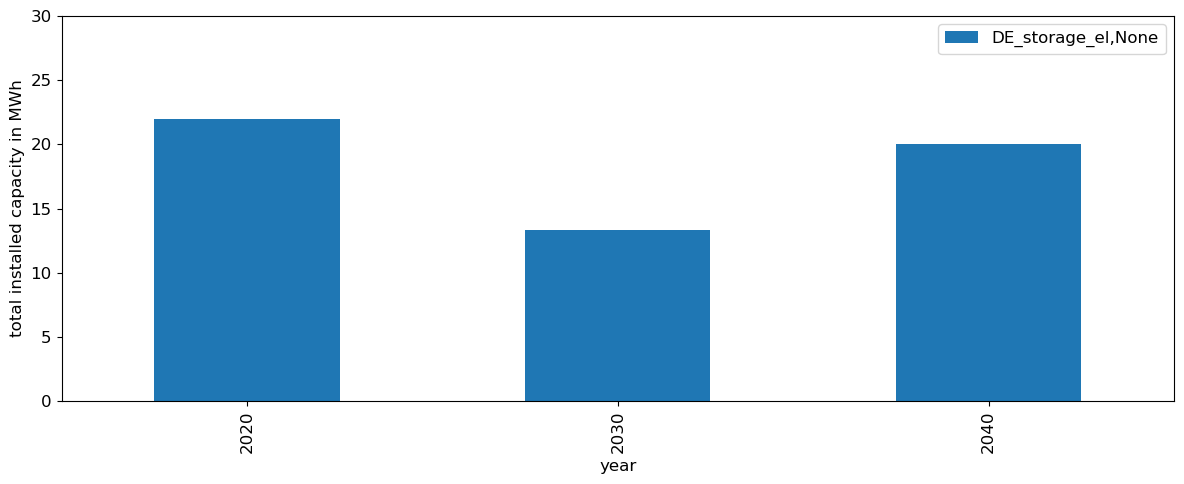

In [14]:
# Show the total installed capacity
plot_single_investment_variable_multiple_dfs(
    [investment_results, storage_investment_results],
    "total",
    ylim=[0, 30]
)

In [15]:
# Show the data frames containing all the infos we visualized above.
display(pd.concat([investment_results, storage_investment_results]))

variable_name                        invest        old    old_end  old_exo   
label                       year                                             
DE_bus_el,DE_storage_el     2020   2.400000   0.000000   0.000000      0.0  \
                            2030   2.666667   4.400000   2.400000      2.0   
                            2040   4.000000   2.666667   2.666667      0.0   
DE_pp_hardcoal,DE_bus_el    2020   0.000000   0.000000   0.000000      0.0   
                            2030   0.000000   0.000000   0.000000      0.0   
                            2040   0.000000   0.000000   0.000000      0.0   
DE_pp_lignite,DE_bus_el     2020   0.000000   0.000000   0.000000      0.0   
                            2030   0.000000   0.000000   0.000000      0.0   
                            2040   0.000000   0.000000   0.000000      0.0   
DE_pp_natgas_CCGT,DE_bus_el 2020   0.000000   0.000000   0.000000      0.0   
                            2030   0.000000   0.000000   0.000000      0.0   
                            2040   0.000000   0.000000   0.000000      0.0   
DE_pp_natgas_GT,DE_bus_el   2020  10.600005   0.000000   0.000000      0.0   
                            2030   4.811523   0.000000   0.000000      0.0   
                            2040   6.188482  10.600005  10.600005      0.0   
DE_storage_el,DE_bus_el     2020   2.400000   0.000000   0.000000      0.0   
                            2030   2.666667   4.400000   2.400000      2.0   
                            2040   4.000000   2.666667   2.666667      0.0   
DE_storage_el,None          2020  20.000000   0.000000   0.000000      0.0   
                            2030  13.333333  22.000000  20.000000      2.0   
                            2040  20.000000  13.333333  13.333333      0.0   

variable_name                         total  
label                       year             
DE_bus_el,DE_storage_el     2020   4.400000  
                            2030   2.666667  
                            2040   4.000000  
DE_pp_hardcoal,DE_bus_el    2020   0.000000  
                            2030   0.000000  
                            2040   0.000000  
DE_pp_lignite,DE_bus_el     2020   0.000000  
                            2030   0.000000  
                            2040   0.000000  
DE_pp_natgas_CCGT,DE_bus_el 2020   0.000000  
                            2030   0.000000  
                            2040   0.000000  
DE_pp_natgas_GT,DE_bus_el   2020  10.600005  
                            2030  15.411528  
                            2040  11.000005  
DE_storage_el,DE_bus_el     2020   4.400000  
                            2030   2.666667  
                            2040   4.000000  
DE_storage_el,None          2020  22.000000  
                            2030  13.333333  
                            2040  20.000000

## Dispatch results
Filter and show some dispatch results.<br>
The following plots are created:
* 

In [16]:
# Filter the respective results
filter_values = {
    "demand": [
        col for col in dispatch_results.columns if "sink" in col
    ],
    "generation": [
        col for col in dispatch_results.columns 
        if "source" in col or "pp" in col
    ],
    "storage_inflow": ["DE_bus_el,DE_storage_el"],
    "storage_outflow": ["DE_storage_el,DE_bus_el"],
}

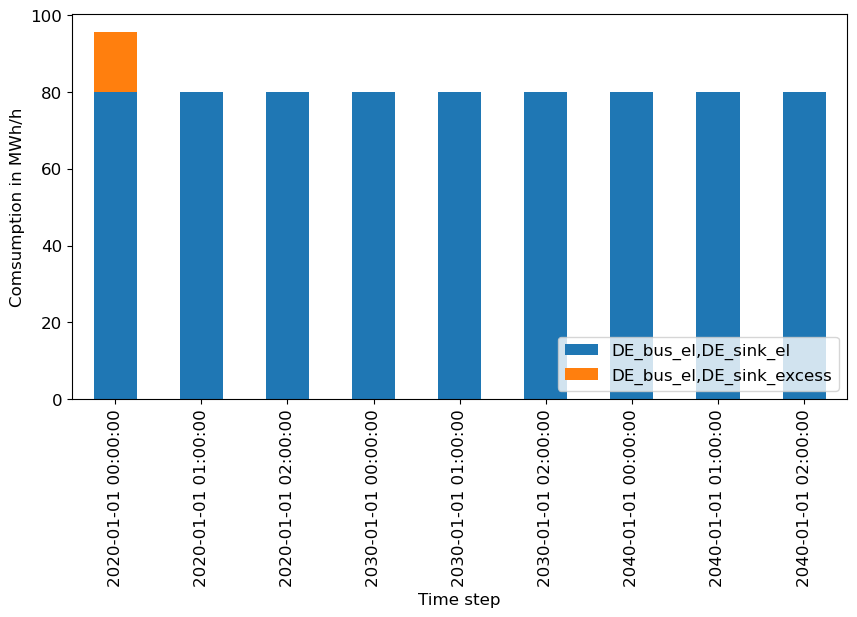

In [17]:
# Demand
fig, ax = plt.subplots(figsize=(10,5))
dispatch_results[filter_values["demand"]].plot(kind="bar", stacked=True, ax=ax)
plt.ylabel("Comsumption in MWh/h")
plt.xlabel("Time step")
plt.legend(loc="lower right")
plt.show()

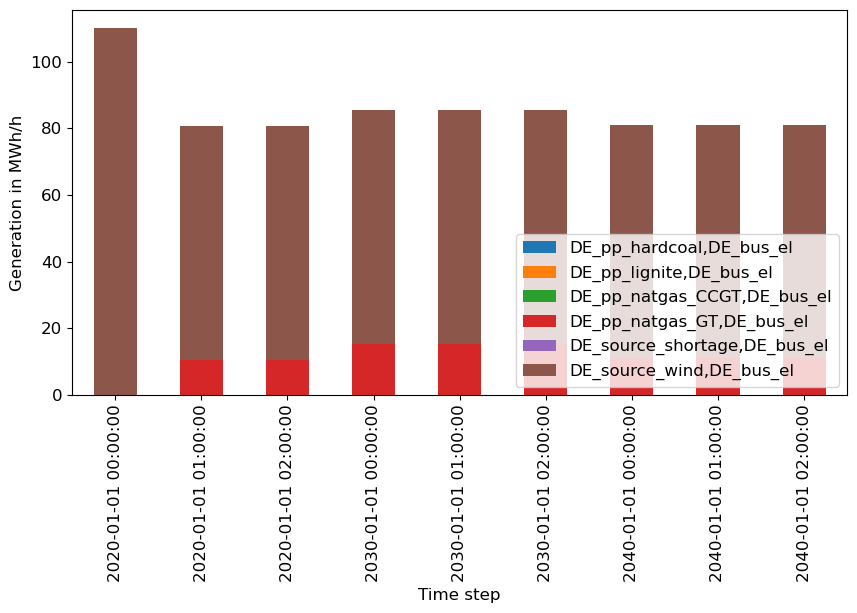

In [18]:
# Generation
fig, ax = plt.subplots(figsize=(10,5))
dispatch_results[filter_values["generation"]].plot(kind="bar", stacked=True, ax=ax)
plt.ylabel("Generation in MWh/h")
plt.xlabel("Time step")
plt.legend(loc="lower right")
plt.show()

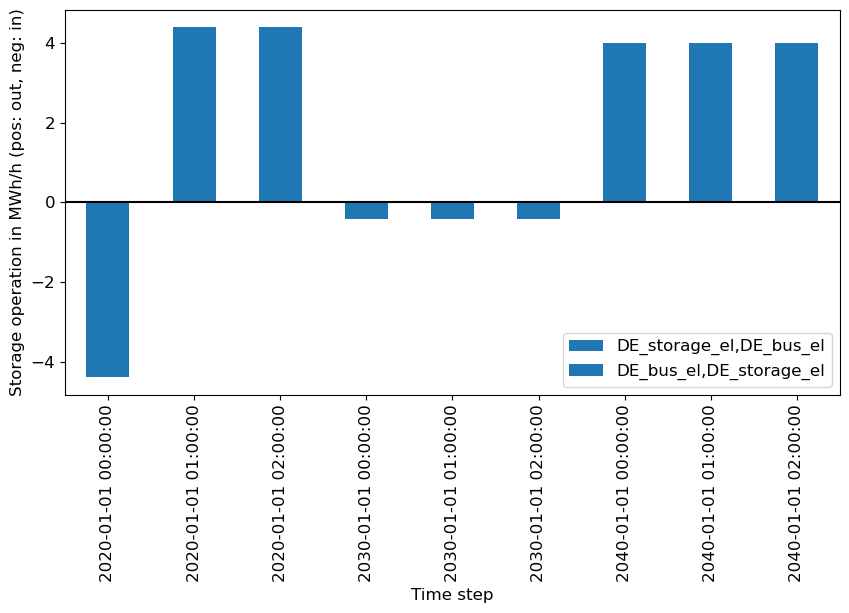

In [19]:
# Storages
fig, ax = plt.subplots(figsize=(10,5))
dispatch_results[filter_values["storage_outflow"]].plot(kind="bar", ax=ax)
dispatch_results[filter_values["storage_inflow"]].mul(-1).plot(kind="bar", ax=ax)
plt.axhline(y=0, color='k', linestyle='-')
plt.ylabel("Storage operation in MWh/h (pos: out, neg: in)")
plt.xlabel("Time step")
plt.legend(loc="lower right")
plt.show()